
# Flowers Dataset Classifier with PyTorch 🌸💐

https___dev-to-uploads.s3.amazonaws.com_i_3u3m12hed9vvvmgwdkxb.avif

## Objective:

We have 5 Classes of flowers [Daisy, Dandelion, Rose, Sunflower, Tulip] and we want to train a deep learning model with pytorch to be able to classify these flowers

## Importing libraries and Data

In [1]:
# Get the data direct from google drive.
# access to google drive.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Importing Main libraries

In [2]:
# Main Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import os
import torchvision

# PyTorch Data Loading and Preprocesing Libraries
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
from torchvision.datasets.utils import download_url
from torchvision.transforms import ToTensor
from torchvision.io import read_image
from PIL import Image

# PyTorch Model Implementation Libraries
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter

### Loading and Preprocessing the data

#### Extracting Dataset

In [3]:
# Extracting Data from Google Drive in Temporary Content Folder

!unzip -qq "/content/drive/MyDrive/FlowerClassifier/archive .zip" -d "./content"


#### Define Transformation

In [4]:
# Define preprocessing and augmentation transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

#### Creating Dataset

In [5]:
# prompt: get the data from the extracted zip file

#pc dirictory --> it's for switching from colab to pycharm to prevent error skip.....
#train_dir = "./Data/train"
#test_dir = "./Data/test"

# for colab
train_dir = "/content/content/train"
test_dir = "/content/content/test"


train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms["train"], target_transform=None)

print(f"Train data:\n{train_dataset}")

Train data:
Dataset ImageFolder
    Number of datapoints: 2746
    Root location: /content/content/train
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


#### Loading Test dataset

**Note**: Since the test data folder has no subfolders nor labels, we cannot use ImageFolder or DataLoader methods. These methods expect a certain structure of the dataset and cannot work with unlabeled data.

Unlabeled test data lacks structure: Since the test data doesn't have labels or subfolders, it doesn't follow the same structure as the training data. We don't need functionalities like batching or shuffling for this specific scenario.

In [6]:
def load_process_images(image_path):

  img = Image.open(image_path)

  # Apply same transformation done on train data
  img = transforms.Resize(256)(img)
  img = transforms.CenterCrop(224)(img)
  img = transforms.ToTensor()(img)
  img = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(img)

  #return image as a tensor
  return img

* Therefore, we iterate through the test images manually using a for loop.
* Load each image individually, preprocess it, and store it in a list along with the placeholder label.
* This allows us to feed the preprocessed images to the model for prediction without relying on DataLoaders.

In [7]:
test_images = []
test_labels = []

for filename in os.listdir(test_dir):
  if filename.endswith(".jpg") or filename.endswith(".png"):
    image_path = os.path.join(test_dir, filename)

    image = load_process_images(image_path)

    image = torch.squeeze(image, 0)

    test_images.append(image)
    test_labels.append(-1)


Check work
* check shape and type of the resulting test images

In [8]:
test_images[0].shape, test_images[0].dtype

(torch.Size([3, 224, 224]), torch.float32)

In [9]:
print(f'Class Names: {train_dataset.classes}')
sample_img, sample_idx = train_dataset[0]
print(f'Sample Image Shape: {sample_img.shape}')
print(f'Sample Image type: {sample_img.dtype}')
print(f'Sample Index {sample_idx}')

Class Names: ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']
Sample Image Shape: torch.Size([3, 224, 224])
Sample Image type: torch.float32
Sample Index 0


## Load the Train Data using DataLoaders

In [10]:
# Create data loaders for training and testing datasets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

len(train_loader)

86

## Visualize Few Random Images

In [11]:
# Get a batch of training data
inputs, classes = next(iter(train_loader))
inputs.shape, classes.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

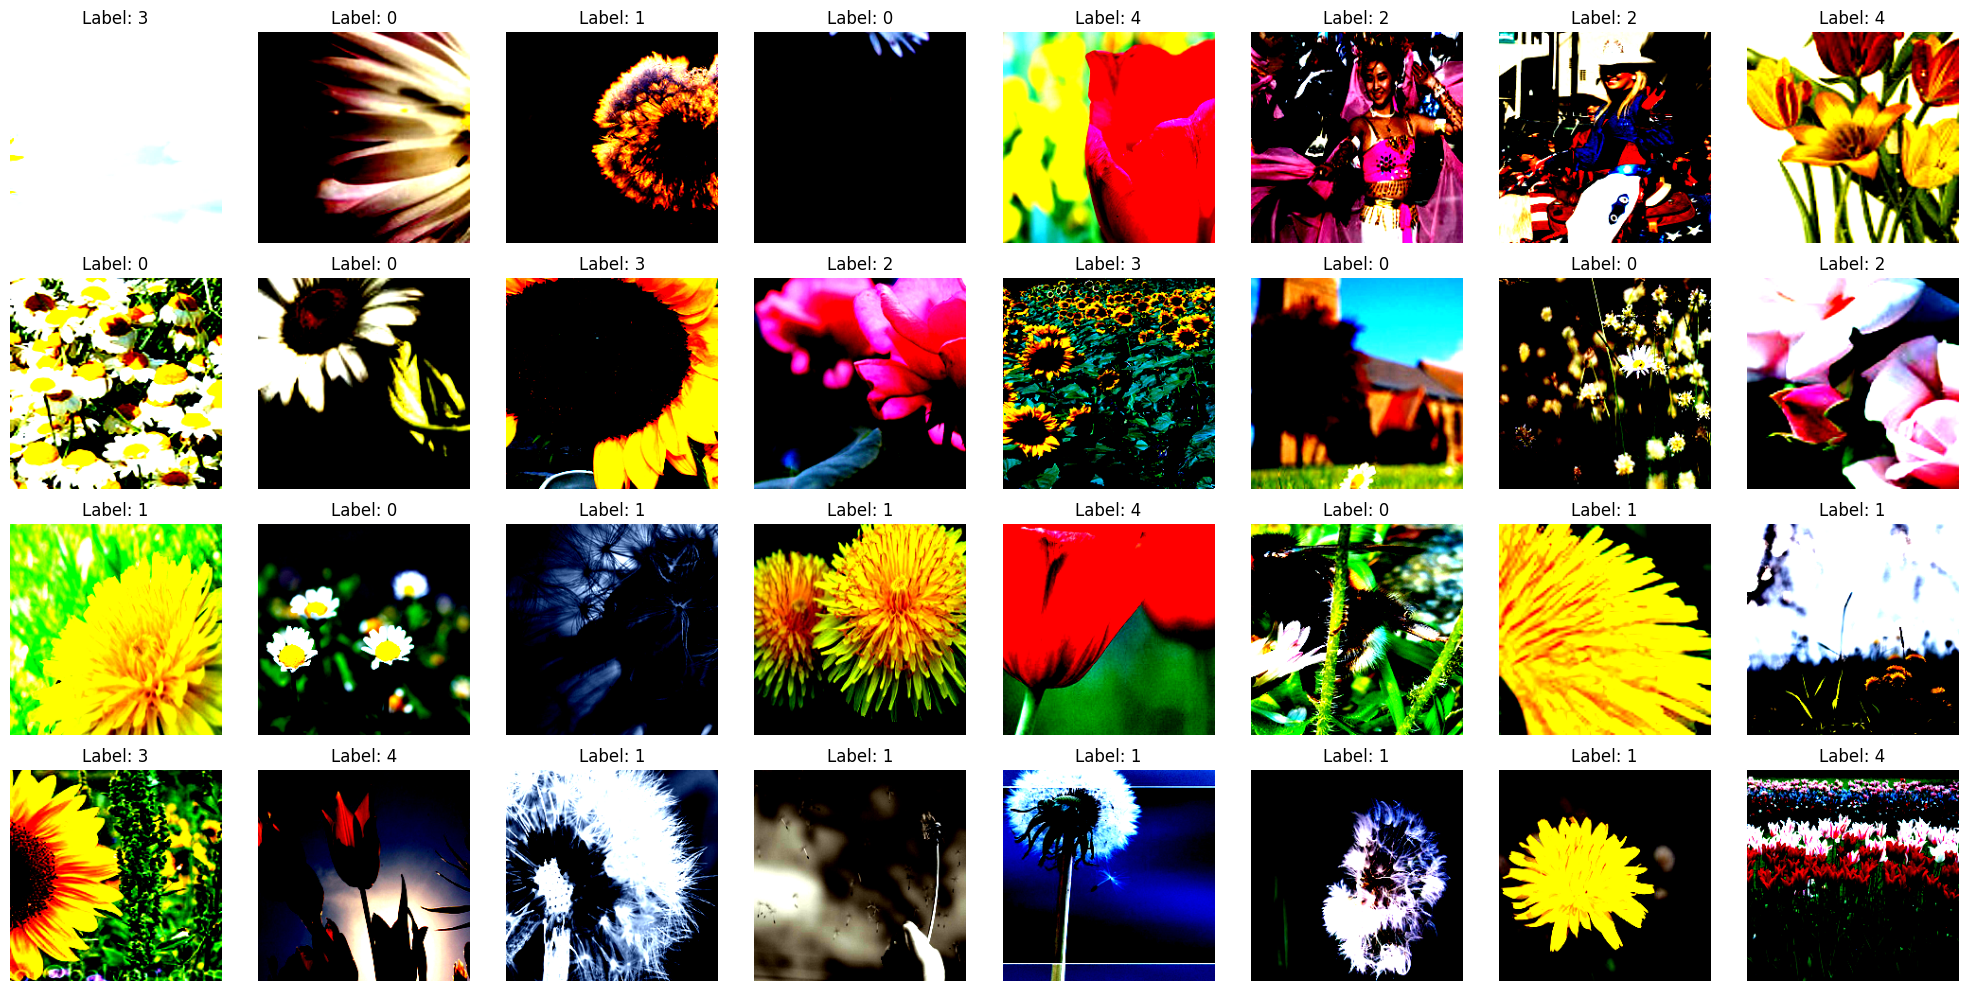

In [12]:
# Display the first batch of images and labels from the training data
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
axes = axes.flatten()
# Display images and labels
for i in range(32):
    image, label = inputs[i], classes[i]
    image = image.permute(1, 2, 0)
    axes[i].imshow(image)
    axes[i].set_title(f"Label: {label}")
    axes[i].axis('off')
plt.tight_layout()
plt.show();

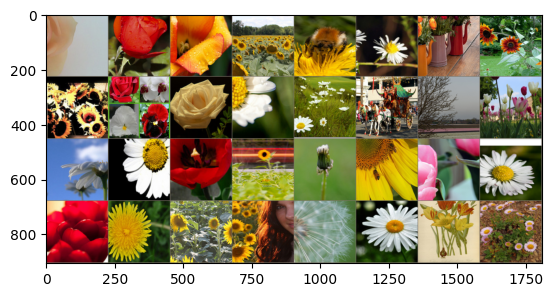

In [13]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(train_loader))
# Make a grid from batch
out = torchvision.utils.make_grid(inputs)
imshow(out)

## Buliding the Neural Network

In [14]:
# Build neural network model
class FlowerClassifier(nn.Module):
    def __init__(self):
        super(FlowerClassifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.fc = nn.Linear(self.model.fc.in_features, 5)

    def forward(self, x):
        return self.model(x)



In [15]:
# Create an instance of the model
model = FlowerClassifier()
model

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 110MB/s]


FlowerClassifier(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, tr

In [16]:
# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [17]:
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cuda')

In [18]:
# Move the model to the device
model = model.to(device)

In [19]:
# Define a function to train the model
def train_model(model, criterion, optimizer, num_epochs=5):
    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in tqdm(train_loader):
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(train_dataset)
            epoch_acc = running_corrects.double() / len(train_dataset)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

    return model

In [20]:
# Train the model
model = train_model(model, criterion, optimizer, num_epochs=5)

Epoch 1/5
----------


  0%|          | 0/86 [00:00<?, ?it/s]

Train Loss: 0.8275 Acc: 0.7090
Epoch 2/5
----------


  0%|          | 0/86 [00:00<?, ?it/s]

Train Loss: 0.6008 Acc: 0.7782
Epoch 3/5
----------


  0%|          | 0/86 [00:00<?, ?it/s]

Train Loss: 0.5333 Acc: 0.8001
Epoch 4/5
----------


  0%|          | 0/86 [00:00<?, ?it/s]

Train Loss: 0.5105 Acc: 0.8110
Epoch 5/5
----------


  0%|          | 0/86 [00:00<?, ?it/s]

Train Loss: 0.4909 Acc: 0.8299


## Transfer Learning Model

In [21]:
# Define the ResNet model
def initialize_resnet(num_classes, feature_extract=True):
    # Load pre-trained ResNet model
    model_ft = models.resnet50(weights=models.resnet.ResNet50_Weights.DEFAULT)  # Specify weights

    # Freeze the weights of the pre-trained layers
    if feature_extract:
        for param in model_ft.parameters():
            param.requires_grad = False

    # Replace the fully connected layer with a new one (unfrozen by default)
    num_ftrs = model_ft.fc.in_features
    model_ft.fc = nn.Linear(num_ftrs, num_classes)

    return model_ft

# Number of classes in the dataset
num_classes = len(train_dataset.classes)

# Initialize the ResNet model for transfer learning
resnet_model = initialize_resnet(num_classes)

# to Print the model architecture
# print(resnet_model)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 123MB/s]


### Create an optimizer and a Loss Function


In [22]:
# Instantiate the model
model = resnet_model
# Move the model to GPU
model.to(device)
# Create a loss function and an optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Create Trainig and Testing Functions for the Model

In [23]:
# Define the number of epochs
num_epochs = 10
model.to(device)

# Training Loop
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    train_correct_predictions = 0
    total_train_samples = 0

    for inputs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} - Training", unit="batch"):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()

        # Compute training evaluation metrics
        train_loss += loss.item() * inputs.size(0)
        train_correct_predictions += (torch.argmax(outputs, axis=1) == labels).sum().item()
        total_train_samples += inputs.size(0)

    # Compute average training loss and accuracy
    avg_train_loss = train_loss / len(train_loader.dataset)
    train_accuracy = train_correct_predictions / total_train_samples

    print(f"Epoch {epoch+1}/{num_epochs} - Average Training Loss: {avg_train_loss:.4f}, Training Accuracy: {train_accuracy:.4f}")

Epoch 1/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 1/10 - Average Training Loss: 0.9244, Training Accuracy: 0.7378


Epoch 2/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 2/10 - Average Training Loss: 0.5258, Training Accuracy: 0.8532


Epoch 3/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 3/10 - Average Training Loss: 0.4079, Training Accuracy: 0.8813


Epoch 4/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 4/10 - Average Training Loss: 0.3800, Training Accuracy: 0.8878


Epoch 5/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 5/10 - Average Training Loss: 0.3428, Training Accuracy: 0.9002


Epoch 6/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 6/10 - Average Training Loss: 0.3118, Training Accuracy: 0.9039


Epoch 7/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 7/10 - Average Training Loss: 0.3098, Training Accuracy: 0.9028


Epoch 8/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 8/10 - Average Training Loss: 0.2904, Training Accuracy: 0.9009


Epoch 9/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 9/10 - Average Training Loss: 0.2627, Training Accuracy: 0.9162


Epoch 10/10 - Training:   0%|          | 0/86 [00:00<?, ?batch/s]

Epoch 10/10 - Average Training Loss: 0.2574, Training Accuracy: 0.9246


Number of test images: 924
Predicted class distribution:
daisy: 134
dandelion: 244
rose: 143
sunflower: 203
tulip: 200


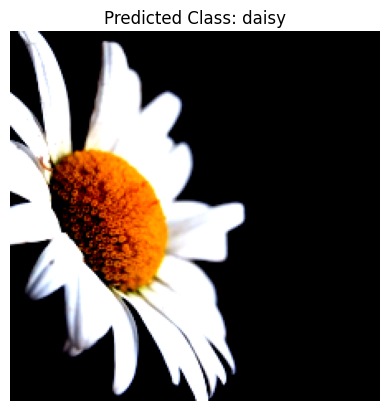

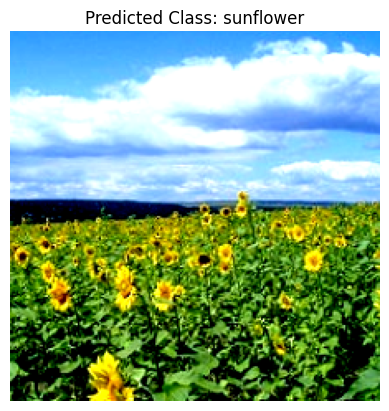

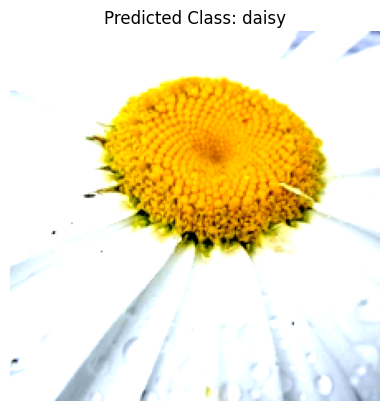

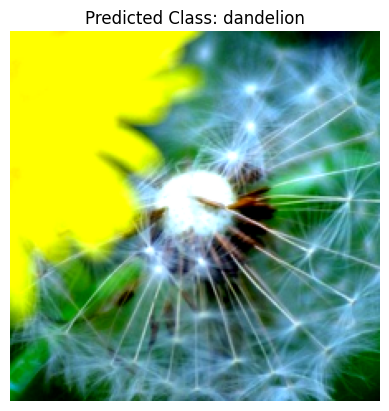

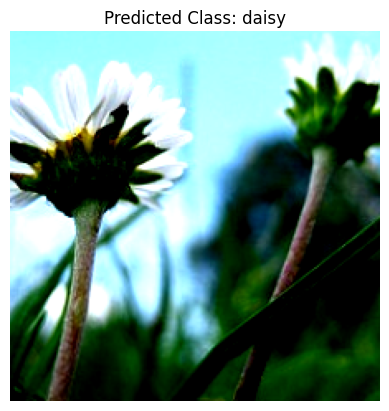

In [24]:
import matplotlib.pyplot as plt

def evaluate_model(model, test_images, test_labels, class_names):
    """
    This function evaluates the model on the test data, prints some basic metrics, and visualizes some images with their predicted classes.
    """
    model.eval()  # Set the model to evaluation mode

    # Initialize variables to track predictions and true labels (optional)
    predicted_labels = []
    true_labels = []  # This will be filled with -1s for unlabeled data

    with torch.no_grad():
        for image in test_images:
            # Forward pass
            image = image.to(device)
            image = image.unsqueeze(0)
            output = model(image)  # Add batch dimension
            _, predicted = torch.max(output.data, 1)

            # Store predictions and true labels (optional)
            predicted_labels.append(predicted.item())
            true_labels.append(-1)  # Placeholder for unlabeled data

    # Since you don't have true labels, traditional metrics like accuracy cannot be calculated.
    # However, you can still print some basic information about the predictions:

    # Print the number of images
    print(f"Number of test images: {len(test_images)}")

    # Print the predicted class distribution (optional)
    class_counts = np.bincount(predicted_labels)
    print(f"Predicted class distribution:")
    for i, count in enumerate(class_counts):
        print(f"{class_names[i]}: {count}")

    # Visualize some images along with their predicted classes
    num_images_to_visualize = 5  # Choose the number of images to visualize
    for i in range(num_images_to_visualize):
        image = test_images[i]  # Get the i-th test image
        predicted_class_index = predicted_labels[i]  # Get the predicted class index for the i-th image

        # Convert the PyTorch tensor to a NumPy array and transpose the dimensions
        # Reverse normalization (assuming mean=0.5, std=0.5 for each channel)
        image = image.cpu().numpy().transpose(1, 2, 0)  # Convert to NumPy and transpose dimensions
        image = (image * 0.5) + 0.5  # Rescale to [0, 1] range
        image = np.clip(image, 0, 1)  # Clip values to [0, 1] in case of overflow

        # Plot the image
        plt.figure()
        plt.imshow(image)
        plt.title(f"Predicted Class: {class_names[predicted_class_index]}")
        plt.axis('off')
        plt.show()

    # Save predicted labels to a CSV file for submission on Kaggle
    submission_df = pd.DataFrame({'predictions': [class_names[i] for i in predicted_labels]})
    submission_df.to_csv('submission.csv', index=False)

# After defining the testing loop, call it with your model, test data, and class names:
evaluate_model(model, test_images, test_labels, class_names=['daisy', 'dandelion', 'rose', 'sunflower', 'tulip'])

# Thank you :❤️❤️